In [26]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import numpy as np
import os
import time
from matplotlib import pyplot as plot

# 1. Загрузка данных

In [27]:
dir_name = os.getcwd()
batch_size = 100

In [28]:
norm_std = (0.5, 0.5, 0.5)
norm_mean = (0.5, 0.5, 0.5)

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(norm_std, norm_mean)])
train_dataset = torchvision.datasets.CIFAR10(root = dir_name, train = True, download = True,transform = transforms)
test_dataset = torchvision.datasets.CIFAR10(root = dir_name, train = False, download = True,transform = transforms)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


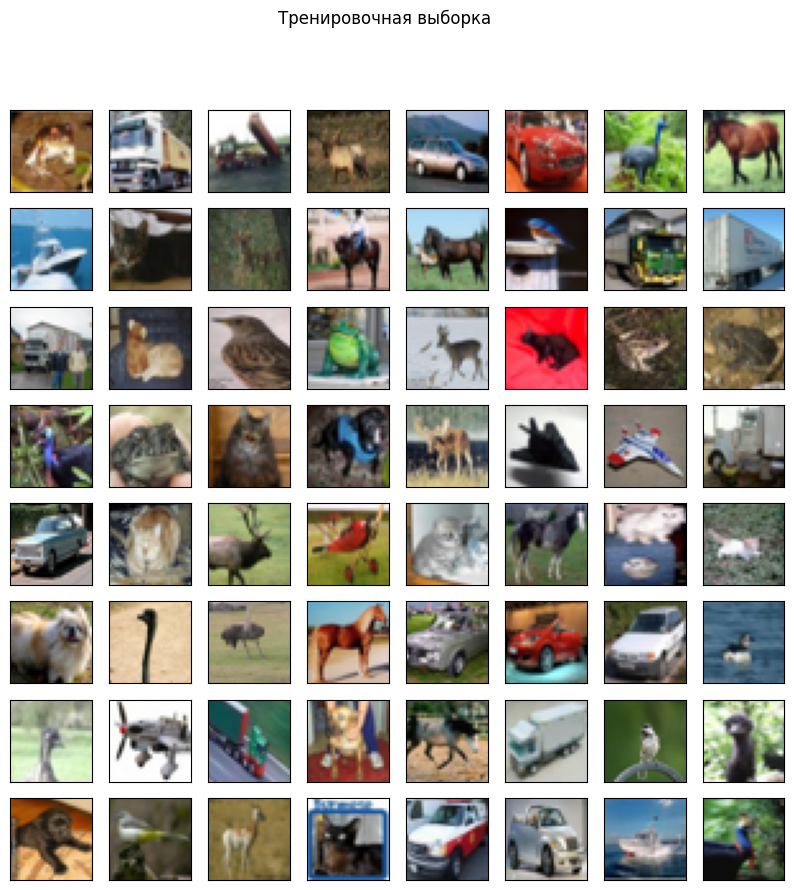

In [29]:
fig, axes = plot.subplots(8, 8, figsize = (10, 10))
fig.suptitle('Тренировочная выборка')
plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    original_img = train_dataset[i][0] * torch.tensor(norm_std).reshape(3, 1, 1) + torch.tensor(norm_mean).reshape(3, 1, 1)
    img = original_img.numpy().transpose(1, 2, 0)
    ax.imshow((img * 255).astype('uint8'))

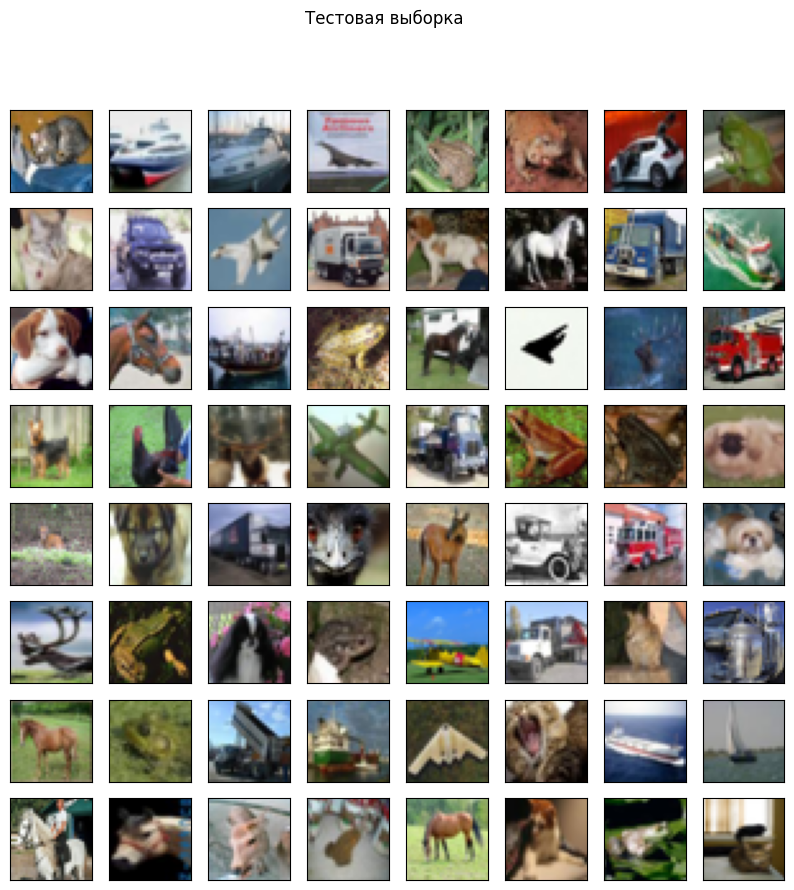

In [30]:
fig, axes = plot.subplots(8, 8, figsize = (10, 10))
fig.suptitle('Тестовая выборка')
plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    original_img = test_dataset[i][0] * torch.tensor(norm_std).reshape(3, 1, 1) + torch.tensor(norm_mean).reshape(3, 1, 1)
    img = original_img.numpy().transpose(1, 2, 0)
    ax.imshow((img * 255).astype('uint8'))

In [31]:
print('Размер тренировачной выборки:', len(train_dataset))
print('Размер тестовой выборки:', len(test_dataset))
print()
print('Размерность входных данных тренировочной выборки:', train_dataset[0][0].numpy().shape)
print('Размерность входных данных тестовой выборки:', test_dataset[0][0].numpy().shape)


Размер тренировачной выборки: 50000
Размер тестовой выборки: 10000

Размерность входных данных тренировочной выборки: (3, 32, 32)
Размерность входных данных тестовой выборки: (3, 32, 32)


In [32]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Классы: ', classes)

Классы:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# 2. Построение сверточной нейронной сети

In [35]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = 3, stride = 1)
        self.activation = torch.nn.ReLU()
        self.pooling = torch.nn.MaxPool2d(kernel_size = 3, stride = 1)
        # 28 * 28 * 10
        self.linear = torch.nn.Linear(7840, 10)

    def forward(self, x):
        out = self.conv(x)
        out = self.activation(out)
        out = self.pooling(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# 3. Обучение сети

In [45]:
def get_accuracy(model, data_loader):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            out = model(images)
            _, predict = torch.max(out.data, 1)
            n += labels.size(0)
            tp += (predict == labels).sum()
    return tp / n



def epoch_loss(losses):
  return torch.stack(losses).mean()

In [46]:
cnn_model = CNN()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 0.005)

In [49]:
start_time = time.time()
for epoch in range(20):
    start_epoch = time.time()
    losses = []
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        losses.append(loss)
        loss.backward()
        optimizer.step()

    total_time_epoch = time.time() - start_epoch
    print('Эпоха ', epoch + 1, ': Потери = ', float(epoch_loss(losses)), ', Точность = ', float(get_accuracy(cnn_model, train_data_loader)), '\nВремя: ', total_time_epoch, ' сек.\n')
total_time = time.time() - start_time
print('Суммарное время: ', total_time)

Эпоха  1 : Потери =  1.1487195491790771 , Точность =  0.6393399834632874 
Время:  33.85221815109253  сек.

Эпоха  2 : Потери =  1.1277685165405273 , Точность =  0.6572999954223633 
Время:  34.967421770095825  сек.

Эпоха  3 : Потери =  1.102486491203308 , Точность =  0.663640022277832 
Время:  34.013089179992676  сек.

Эпоха  4 : Потери =  1.086381435394287 , Точность =  0.6518800258636475 
Время:  34.56185579299927  сек.

Эпоха  5 : Потери =  1.0730141401290894 , Точность =  0.6704400181770325 
Время:  34.27135181427002  сек.

Эпоха  6 : Потери =  1.0553654432296753 , Точность =  0.6567000150680542 
Время:  33.612165451049805  сек.

Эпоха  7 : Потери =  1.0419005155563354 , Точность =  0.6588799953460693 
Время:  35.139490604400635  сек.

Эпоха  8 : Потери =  1.033927083015442 , Точность =  0.6833400130271912 
Время:  35.6156747341156  сек.

Эпоха  9 : Потери =  1.0037645101547241 , Точность =  0.6765999794006348 
Время:  33.90391707420349  сек.

Эпоха  10 : Потери =  1.00083434581756

# 4. Точность на тестовой выборке

In [50]:
def get_loss(model, data_loader):
    loss = 0
    with torch.no_grad():
        losses = []
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            out = model(images)
            loss += loss_function(out, labels)
            losses.append(loss)
    return epoch_loss(losses)

In [51]:
print('Потери = ', float(get_loss(cnn_model, test_data_loader)), ', Точность = ', float(get_accuracy(cnn_model, test_data_loader)))

Потери =  155.06777954101562 , Точность =  0.5552999973297119
